    2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.metrics import r2_score
import numpy as np

In [2]:
# сгенерируем данные с двумя признаками и одной целью
classification_data, classification_labels = datasets.make_regression(n_samples=1000, n_features = 2, n_informative = 2, 
                                                      n_targets = 1, random_state=42)

# print(classification_data)
# print(classification_labels)

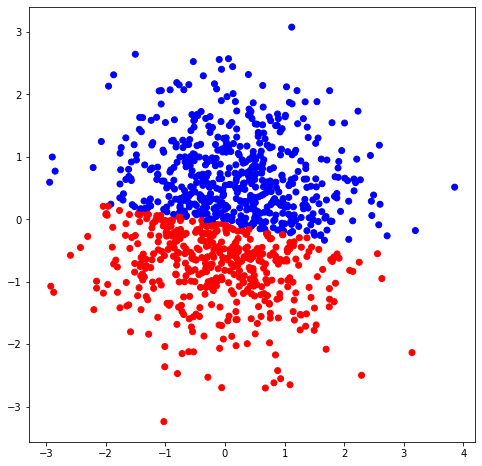

In [3]:
# визуализируем сгенерированные данные 

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла для регрессионного древа

class regression_Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа) для регрессионного древа

class regression_Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # "заменив механизм предсказания в листе на взятие среднего значения по выборке"
        # В данном случае моя выборка это содержимое self.data
#         print(f"Предсказание, данные листа: self.data = {self.labels}")
        prediction = sum(self.labels)/len(self.labels)
#         print(f"После расчёта: {sum(prediction)}")
#         classes = {}  # сформируем словарь "класс: количество объектов"
#         for label in self.labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
#         prediction = max(classes, key=classes.get)
        return prediction    

In [6]:
# def regression_dispersion(labels):
# #     print(f"regression_dispersion: Входящее labels={labels}")
#     # 1. Я вычислил среднее значение, поделив сумму всех элементов выборки на их количество и записал в переменную mean_value
#     mean_value = sum(labels)/len(labels) #Среднее значение выборки
#     print(f"    Среднее значение: {mean_value}")
#     #Теперь мне нужно посчитать дисперсию. Для этого я должен посчитать сумму квадратов разницы каждого элемента labels
#     #с meav_value
# #     for i in labels:
# #         dispersion += (i-mean_value)**2
# #         print(dispersion)
#     dispersion = (labels - mean_value)**2
# #     print(f"    Дисперсия: {dispersion}")
#     dispersion = (sum(dispersion))/len(labels)
#     print(f"    Sum Дисперсия: {dispersion}")
#     return dispersion

In [7]:
def regression_avg(labels):
    return sum(labels)/len(labels)

In [8]:
# Расчет качества, тут наверное должно быть какое-нибудь р2_скоре

def regression_quality(left_labels, right_labels, current_quality):
    p = len(left_labels)/(len(left_labels)+len(right_labels))
    return p*(sum(left_labels)/len(left_labels)) + (1-p)*(sum(right_labels)/len(right_labels))

In [9]:
# Нахождение наилучшего разбиения при регрессии. 

def regression_find_best_split(data, labels, max_leaf):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1
    # Прежде чем искать лучшее разбиение, мы определяем его текущее состояние
    # Что такое лучшее разбиение?
    current_quality = regression_avg(labels)
#     print(f"Первичный расчёт квалити: {current_quality}")
    best_quality = 0
    best_t = None
    best_index = None
    n_features = [0,1]
    for index in n_features: 
        t_values = np.unique([row[index] for row in data])
        
#         print(f"/    Текущий index: {index}")
        for t in t_values: 
            #Перебираем все значение в t_values, используя их как разделители для дерева
            true_data, false_data, true_labels, false_labels = regression_split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
#                 print(f"/        НЕ Достигнут лимит min_leaf={min_leaf}")
                continue
#             if len(true_data) > max_leaf or len(false_data) > max_leaf:
#                 print(f"/        Достигнут лимит max_leaf={max_leaf}")
#                 continue

            current_quality = regression_quality(true_labels, false_labels, current_quality)
#             print(f"/        current_quality = {current_quality}")
                #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
#                 print(f"/        current_quality({current_quality}) > best_quality({best_quality})")
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Разбиение датасета в узле

def regression_split(data, labels, index, t):
#     print(f"входные data = {data}")
#     print(f"входные labels = {labels}")
#     print(f"index = {index}")
#     print(f"t = {t}")
    left = np.where(data[:, index] <= t)
#     print(f"split . left = {left}")
    right = np.where(data[:, index] > t)
#     print(f"split . right = {right}")
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Построение дерева с помощью рекурсивной функции

def regression_build_tree(data, labels):
    quality, t, index = regression_find_best_split(data, labels, max_leaf=60)
#     print(f"regression_build_tree: quality, t, index = {quality, t, index}")
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0: 
#         print(f"/    Строю лист из следующих данных")
#         print(f"/    возвратные data = {data}")
#         print(f"/    возвратные labels = {labels}")
        return regression_Leaf(data, labels) #Формируем лист из полученных data и labels,
        #иначе
    
    #разбиваем текущее содержимое data и labels с помощью index и t, найденных функцией find_best_split
#     print(f"/    regression_split(data, labels, {index}, {t})")
    true_data, false_data, true_labels, false_labels = regression_split(data, labels, index, t)
    
    # Рекурсивно строим два поддерева
    true_branch = regression_build_tree(true_data, true_labels)
    false_branch = regression_build_tree(false_data, false_labels)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
#     print("Конец функции build_tree")
    return regression_Node(index, t, true_branch, false_branch)

In [12]:
def regression_predict_something(obj, node):
#     print(f"regression_predict_something")
#     print(f"    Получено на вход obj = {obj}")
#     print(f"    Получено на вход node = {node}")
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, regression_Leaf):
#         print(f"        node={node}")
#         print(f"regression_Leaf={regression_Leaf.keys}")
        answer = node.prediction
#         print(f"        Ответ:{answer}")
        return answer
    
#     print(f"    node.t={node.t}")
#     print(f"    regression_Leaf={regression_Leaf}")
    
    if obj[node.index] <= node.t:
        return regression_predict_something(obj, node.true_branch)
    else:
        return regression_predict_something(obj, node.false_branch)

In [13]:
def regression_predict(data, tree):
#     print(data)
    
    classes = []
    for obj in data:
        prediction = regression_predict_something(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 42)
# classification_labels

In [15]:
# Построим дерево по обучающей выборке
my_tree = regression_build_tree(train_data, train_labels)


In [16]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, regression_Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог -1.1057046684859357
--> True:
  Прогноз: -63.91783585526986
--> False:
  Индекс 1
  Порог 2.4457519796168263
  --> True:
    Индекс 0
    Порог -1.1246420918378692
    --> True:
      Прогноз: -3.274654864549202
    --> False:
      Индекс 1
      Порог -1.0810633275998973
      --> True:
        Прогноз: -40.71601654560834
      --> False:
        Индекс 0
        Порог -1.1196174332890112
        --> True:
          Прогноз: -27.29195440826081
        --> False:
          Индекс 1
          Порог 2.1573082132655035
          --> True:
            Индекс 1
            Порог 2.0740826697499735
            --> True:
              Индекс 1
              Порог 2.060747924881987
              --> True:
                Индекс 1
                Порог -0.9896281365703375
                --> True:
                  Прогноз: -41.195936003177536
                --> False:
                  Индекс 0
                  Порог -1.1065259087416703
                  --> True:
           

In [17]:
my_tree

In [18]:
# Получим ответы для обучающей выборки 
train_answers = regression_predict(train_data, my_tree)
# [-0.14312642 -0.22418983] -2.72879581

In [19]:
# train_answers

In [20]:
# И получим ответы для тестовой выборки
answers = regression_predict(test_data, my_tree)

In [21]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [22]:
train_accuracy = r2_score(train_labels, train_answers)

In [23]:
test_accuracy = r2_score(test_labels, answers)

In [24]:
# np.array(train_answers)

Text(0.5, 1.0, 'Test accuracy=0.87')

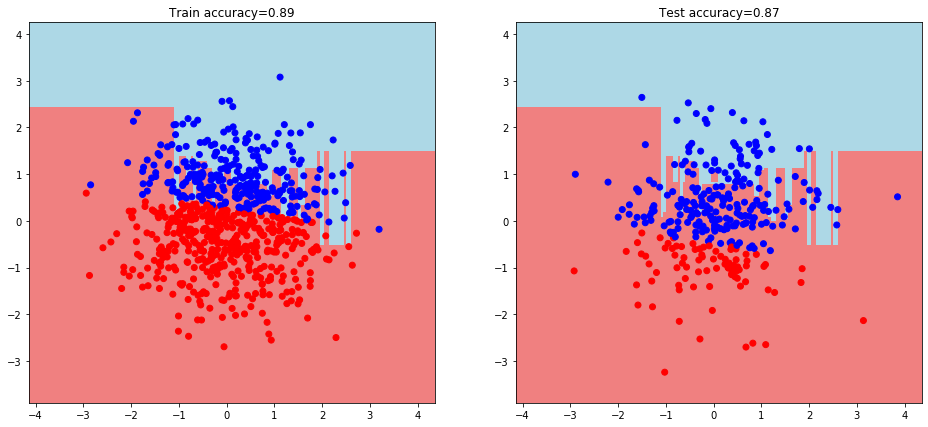

In [25]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

# print(predict(np.c_[xx.ravel(), yy.ravel()], my_tree))

mesh_predictions = np.array(regression_predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')